In [104]:
# https://software.intel.com/en-us/articles/visualising-cnn-models-using-pytorch

In [92]:
import torch
from torch import nn
from torchvision import models
import cv2 as cv
from skimage import data
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F

In [10]:
cat = data.chelsea()

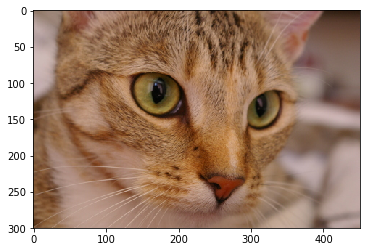

In [12]:
plt.imshow(cat)

In [87]:
imagenet_stats = [(0.485, 0.456, 0.406), (0.229, 0.224, 0.225)]

In [93]:
def create_model(arch=models.resnet50, device=torch.device('cpu')):
    net = arch(pretrained=True)
#     num_of_filters = net.fc.in_features
#     net.fc = nn.Linear(num_of_filters, 2)
    net.to(device)
    net.eval()
    return net

In [94]:
def preprocess_image(img, resize=True, to_rgb=False):
    if resize:
        img = cv.resize(img, (224, 224))
    img_arr = np.float32(img)
    img_arr = np.ascontiguousarray(img_arr[..., ::-1] if to_rgb else img_arr)
    img_arr = img_arr.transpose(2, 0, 1)
    img_ten = torch.from_numpy(img_arr).float()
    img_ten.div_(255)
    img_ten = F.normalize(img_ten, *imagenet_stats)
    img_ten.unsqueeze_(0)
    return img_ten

In [95]:
net = create_model()

In [96]:
image_tensor = preprocess_image(cat)
image_tensor.shape

torch.Size([1, 3, 224, 224])

In [108]:
grad = None

def save_gradient(value):
    global grad
    grad = value
    
def forward_pass_on_convolutions(model, x, target_layer):
    conv_output = None
    for module_name, module in model._modules.items():
        print(module_name)
        if module_name == 'fc':
            return conv_output, x
        x = module(x)
        if module_name == target_layer:
            print(f'Setting hook onto layer: {module_name}')
            x.register_hook(save_gradient)
            conv_output = x
    return conv_output, x

def forward_pass(model, x, target_layer):
    conv_output, x = forward_pass_on_convolutions(model, x, target_layer)
    x = x.view(x.size(0), -1)
    x = model.fc(x)
    return conv_output, x

def generate_cam(model, image, target_layer, target_index=None):
    global grad
    conv_output, model_output = forward_pass(model, image, target_layer)
    if target_index is None:
        target_index = np.argmax(model_output.data.numpy())
    one_hot_output = torch.FloatTensor(1, model_output.size(-1)).zero_()
    one_hot_output[0][target_index] = 1
    model.fc.zero_grad()
    model_output.backward(gradient=one_hot_output, retain_graph=True)
    guided_gradients = grad.data.numpy()[0]
    target = conv_output.data.numpy()[0]
    weights = np.mean(guided_gradients, axis=(1, 2))
    cam = np.ones(target.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        # filters activations weighted averaging
        cam += w*target[i, :, :]
    cam = cv.resize(cam, (224, 224))
    cam = np.maximum(cam, 0)
    cam = (cam - np.min(cam))/(np.max(cam) - np.min(cam))
    cam = np.uint8(cam * 255)
    return cam

In [109]:
cam_image = generate_cam(net, preprocess_image(cat), target_layer='layer4')

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
Setting hook onto layer: layer4
avgpool
fc


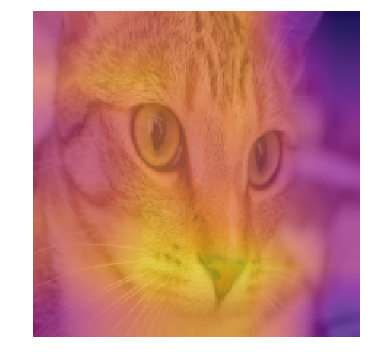

In [119]:
f, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(cv.resize(cat, (224, 224)))
ax.imshow(cam_image, alpha=0.6, cmap='plasma')
ax.set_axis_off()

In [ ]:
# https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

In [102]:
net(preprocess_image(cat)).argmax()

tensor(285)

In [103]:
# 285 -> 'Egyptian cat'